## ThinkDSP

This notebook contains code examples from Chapter 6: Discrete Cosine Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [76]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [77]:
import numpy as np
PI2 = np.pi * 2

### Synthesis

The simplest way to synthesize a mixture of sinusoids is to add up sinusoid signals and evaluate the sum.

In [78]:
from thinkdsp import CosSignal, SumSignal

def synthesize1(amps, fs, ts):
    components = [CosSignal(freq, amp)
                  for amp, freq in zip(amps, fs)]
    signal = SumSignal(*components)

    ys = signal.evaluate(ts)
    return ys

Here's an example that's a mixture of 4 components.

In [79]:
from thinkdsp import Wave

amps = np.array([0.6, 0.25, 0.1, 0.05])
fs = [100, 200, 300, 400]
framerate = 11025

ts = np.linspace(0, 1, framerate, endpoint=False)
ys = synthesize1(amps, fs, ts)
wave = Wave(ys, ts, framerate)
wave.apodize()
wave.make_audio()

We can express the same process using matrix multiplication.

In [80]:
def synthesize2(amps, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    ys = np.dot(M, amps)
    return ys

And it should sound the same.

In [81]:
ys = synthesize2(amps, fs, ts)
wave = Wave(ys, framerate)
wave.apodize()
wave.make_audio()

And we can confirm that the differences are small.

In [82]:
ys1 = synthesize1(amps, fs, ts)
ys2 = synthesize2(amps, fs, ts)
np.max(np.abs(ys1 - ys2))

1.279532035880493e-13

### Analysis

The simplest way to analyze a signal---that is, find the amplitude for each component---is to create the same matrix we used for synthesis and then solve the system of linear equations.

In [83]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

Using the first 4 values from the wave array, we can recover the amplitudes.

In [84]:
n = len(fs)
amps2 = analyze1(ys[:n], fs, ts[:n])
amps2

array([0.6 , 0.25, 0.1 , 0.05])

What we have so far is a simple version of a discrete cosine tranform (DCT), but it is not an efficient implementation because the matrix we get is not orthogonal.

In [85]:
# suppress scientific notation for small numbers
np.set_printoptions(precision=3, suppress=True)

In [86]:
def test1():
    N = 4.0
    time_unit = 0.001
    ts = np.arange(N) / N * time_unit
    max_freq = N / time_unit / 2
    fs = np.arange(N) / N * max_freq
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    return M

M = test1()
M

array([[ 1.   ,  1.   ,  1.   ,  1.   ],
       [ 1.   ,  0.707,  0.   , -0.707],
       [ 1.   ,  0.   , -1.   , -0.   ],
       [ 1.   , -0.707, -0.   ,  0.707]])

To check whether a matrix is orthogonal, we can compute $M^T M$, which should be the identity matrix:

In [87]:
M.transpose().dot(M)

array([[ 4.,  1., -0.,  1.],
       [ 1.,  2.,  1., -0.],
       [-0.,  1.,  2.,  1.],
       [ 1., -0.,  1.,  2.]])

But it's not, which means that this choice of M is not orthogonal.

Solving a linear system with a general matrix (that is, one that does not have nice properties like orthogonality) takes time proportional to $N^3$.  With an orthogonal matrix, we can get that down to $N^2$.  Here's how:

In [88]:
def test2():
    N = 4.0
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    return M
    
M = test2()
M

array([[ 0.981,  0.831,  0.556,  0.195],
       [ 0.831, -0.195, -0.981, -0.556],
       [ 0.556, -0.981,  0.195,  0.831],
       [ 0.195, -0.556,  0.831, -0.981]])

Now $M^T M$ is $2I$ (approximately), so M is orthogonal except for a factor of two.

In [89]:
M.transpose().dot(M)

array([[ 2., -0.,  0.,  0.],
       [-0.,  2., -0., -0.],
       [ 0., -0.,  2., -0.],
       [ 0., -0., -0.,  2.]])

And that means we can solve the analysis problem using matrix multiplication.

In [90]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = M.dot(ys) / 2
    return amps

It works:

In [91]:
n = len(fs)
amps2 = analyze1(ys[:n], fs, ts[:n])
amps2

array([0.6 , 0.25, 0.1 , 0.05])

### DCT

What we've implemented is DCT-IV, which is one of several versions of DCT using orthogonal matrices.

In [92]:
def dct_iv(ys):
    N = len(ys)
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

We can check that it works:

In [93]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
N = 4.0
ts = (0.5 + np.arange(N)) / N
fs = (0.5 + np.arange(N)) / 2
ys = synthesize2(amps, fs, ts)

amps2 = dct_iv(ys)
np.max(np.abs(amps - amps2))

5.551115123125783e-17

DCT and inverse DCT are the same thing except for a factor of 2.

In [94]:
def inverse_dct_iv(amps):
    return dct_iv(amps) * 2

And it works:

In [95]:
amps = [0.6, 0.25, 0.1, 0.05]
ys = inverse_dct_iv(amps)
amps2 = dct_iv(ys)
np.max(np.abs(amps - amps2))

5.551115123125783e-17

###  Dct

`thinkdsp` provides a `Dct` class that encapsulates the DCT in the same way the Spectrum class encapsulates the FFT.

In [96]:
from thinkdsp import TriangleSignal

signal = TriangleSignal(freq=400)
wave = signal.make_wave(duration=1.0, framerate=10000)
wave.make_audio()

To make a Dct object, you can invoke `make_dct` on a Wave.

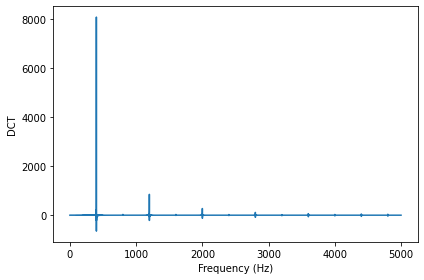

In [97]:
from thinkdsp import decorate

dct = wave.make_dct()
dct.plot()
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Dct provides `make_wave`, which performs the inverse DCT.

In [98]:
wave2 = dct.make_wave()

The result is very close to the wave we started with.

In [99]:
np.max(np.abs(wave.ys-wave2.ys))

7.771561172376096e-16

Negating the signal changes the sign of the DCT.

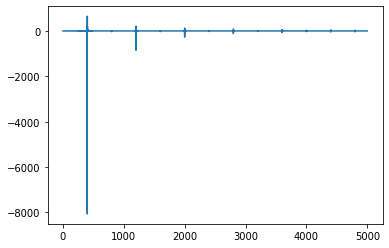

In [100]:
signal = TriangleSignal(freq=400, offset=0)
wave = signal.make_wave(duration=1.0, framerate=10000)
wave.ys *= -1
wave.make_dct().plot()

Adding phase offset $\phi=\pi$ has the same effect.

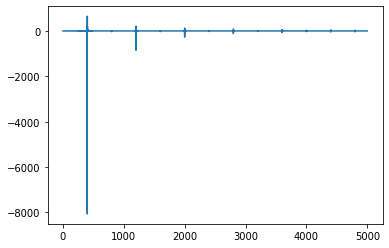

In [101]:
signal = TriangleSignal(freq=400, offset=np.pi)
wave = signal.make_wave(duration=1.0, framerate=10000)
wave.make_dct().plot()

In [102]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

loglog = dict(xscale='log', yscale='log')

def fit_slope(ns, bests):
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [103]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

In [104]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)

In [105]:
ns = 2 ** np.arange(4, 12)
ns

array([  16,   32,   64,  128,  256,  512, 1024, 2048], dtype=int32)

In [106]:
bests = run_speed_test(ns, analyze1)
fit_slope(ns, bests)

16
202 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
32
463 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
64
1.32 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
128
2.62 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
256
6.49 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
13.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
65.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
315 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1.4429081741104806

In [107]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

In [108]:
bests2 = run_speed_test(ns, analyze2)
fit_slope(ns, bests2)

16
15.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
32
20.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
64
73.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
200 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.33 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
7.01 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
29.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
92 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


1.9340330653787678

In [109]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

bests3 = run_speed_test(ns, scipy_dct)
fit_slope(ns, bests3)

16
8.81 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
32
9.91 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
64
10.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
11.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
9.62 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
13.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
16 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
35.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


0.21817871893410304

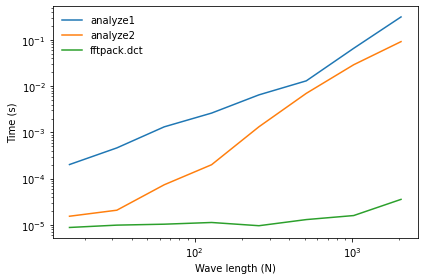

In [110]:
plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
plt.plot(ns, bests3, label='fftpack.dct')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)

In [123]:
import thinkdsp
import thinkplot

wave = thinkdsp.read_wave('100475__iluppai__saxophone-weep.wav')
segment = wave.segment(start=2.0, duration=0.5)
segment.normalize()
segment.make_audio()

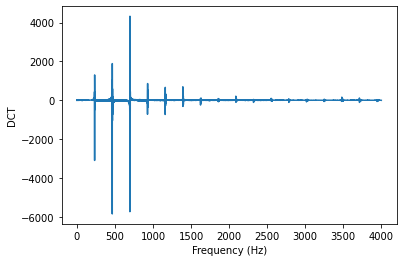

In [124]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='DCT')

In [121]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

21886	22050	99.2562358276644


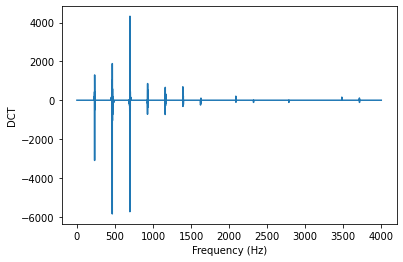

In [126]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=100)
seg_dct.plot(high=4000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='DCT')

In [127]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

In [118]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)
        
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

In [128]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

1018	1024	99.4140625
1016	1024	99.21875
1014	1024	99.0234375
1017	1024	99.31640625
1016	1024	99.21875
1017	1024	99.31640625
1016	1024	99.21875
1020	1024	99.609375
1014	1024	99.0234375
1005	1024	98.14453125
1009	1024	98.53515625
1015	1024	99.12109375
1015	1024	99.12109375
1016	1024	99.21875
1016	1024	99.21875
1015	1024	99.12109375
1017	1024	99.31640625
1020	1024	99.609375
1013	1024	98.92578125
1017	1024	99.31640625
1013	1024	98.92578125
1017	1024	99.31640625
1018	1024	99.4140625
1015	1024	99.12109375
1013	1024	98.92578125
794	1024	77.5390625
785	1024	76.66015625
955	1024	93.26171875
995	1024	97.16796875
992	1024	96.875
976	1024	95.3125
925	1024	90.33203125
802	1024	78.3203125
836	1024	81.640625
850	1024	83.0078125
882	1024	86.1328125
883	1024	86.23046875
891	1024	87.01171875
901	1024	87.98828125
902	1024	88.0859375
900	1024	87.890625
900	1024	87.890625
894	1024	87.3046875
904	1024	88.28125
901	1024	87.98828125
915	1024	89.35546875
913	1024	89.16015625
899	1024	87.79296875
905	1024	88.37

901	1024	87.98828125
894	1024	87.3046875
888	1024	86.71875
780	1024	76.171875
773	1024	75.48828125
750	1024	73.2421875
750	1024	73.2421875
730	1024	71.2890625
761	1024	74.31640625
775	1024	75.68359375
782	1024	76.3671875
788	1024	76.953125
748	1024	73.046875
752	1024	73.4375
771	1024	75.29296875
746	1024	72.8515625
778	1024	75.9765625
777	1024	75.87890625
760	1024	74.21875
734	1024	71.6796875
711	1024	69.43359375
754	1024	73.6328125
745	1024	72.75390625
758	1024	74.0234375
744	1024	72.65625
755	1024	73.73046875
749	1024	73.14453125
723	1024	70.60546875
784	1024	76.5625
761	1024	74.31640625
758	1024	74.0234375
709	1024	69.23828125
769	1024	75.09765625
773	1024	75.48828125
769	1024	75.09765625
756	1024	73.828125
747	1024	72.94921875
787	1024	76.85546875
770	1024	75.1953125
749	1024	73.14453125
769	1024	75.09765625
748	1024	73.046875
761	1024	74.31640625
759	1024	74.12109375
775	1024	75.68359375
756	1024	73.828125
774	1024	75.5859375
776	1024	75.78125
760	1024	74.21875
783	1024	76.4648437

915	1024	89.35546875
927	1024	90.52734375
923	1024	90.13671875
928	1024	90.625
923	1024	90.13671875
914	1024	89.2578125
918	1024	89.6484375
927	1024	90.52734375
926	1024	90.4296875
919	1024	89.74609375
916	1024	89.453125
928	1024	90.625
916	1024	89.453125
933	1024	91.11328125
925	1024	90.33203125
930	1024	90.8203125
930	1024	90.8203125
934	1024	91.2109375
933	1024	91.11328125
935	1024	91.30859375
939	1024	91.69921875
934	1024	91.2109375
938	1024	91.6015625
944	1024	92.1875
937	1024	91.50390625
937	1024	91.50390625
935	1024	91.30859375
937	1024	91.50390625
937	1024	91.50390625
954	1024	93.1640625
940	1024	91.796875
942	1024	91.9921875
955	1024	93.26171875
949	1024	92.67578125
941	1024	91.89453125
947	1024	92.48046875
940	1024	91.796875
943	1024	92.08984375
946	1024	92.3828125
962	1024	93.9453125
954	1024	93.1640625
956	1024	93.359375
957	1024	93.45703125
962	1024	93.9453125
960	1024	93.75
944	1024	92.1875
969	1024	94.62890625
969	1024	94.62890625
969	1024	94.62890625
968	1024	94.53125
9